In [1]:
# requires Python 2 #

In [2]:
# READ DATA OnlineRetail.xlsx

import pandas as pd
dfs = pd.read_excel('C:\Users\kumarsa\Desktop\Sudodesktop\R&C DTS\OnlineRetail.xlsx', sheet_name='OnlineRetail', index = 'InvoiceDate')

In [3]:
# Meta data
#exploring the unique values

print "Total Number of Interactions #", dfs['InvoiceNo'].count()
print "Number of Unique Interactions #", dfs['InvoiceNo'].nunique()
print "Number of Unique products bought #",dfs['StockCode'].nunique()
print "Number of Unique customers #", dfs['CustomerID'].nunique()
print "Percentage of NA customers %", round(dfs['CustomerID'].isnull().sum() * 100 / len(dfs),2)
print 'Number of countries #',dfs['Country'].nunique()

Total Number of Interactions # 541909
Number of Unique Interactions # 25900
Number of Unique products bought # 4070
Number of Unique customers # 4372
Percentage of NA customers % 24.0
Number of countries # 38


In [4]:
# Cancelled invoices
# Few InvoiceNo start with the letter "c" = cancelled.

cancelled_orders = dfs[dfs['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

In [5]:
#check how many rows our dataframe of cancelled orders contain

total_orders = dfs['InvoiceNo'].nunique()
cancelled_number = len(cancelled_orders)
print 'Number of Canceled Orders #',cancelled_number

Number of Canceled Orders # 9288


In [6]:
#remove canceled orders

dfs = dfs[dfs['Quantity']>0]
dfs.shape

(531285, 8)

In [7]:
#remove rows where customerID is NA

dfs.dropna(subset=['CustomerID'],how='all',inplace=True)
dfs.shape

(397924, 8)

In [8]:
#Add a new column AmountSpend: Multiplying Quantity and UnitPrice columns

dfs['AmountSpend'] = dfs['Quantity']*dfs['UnitPrice']

In [9]:
## Keeping relevant coluns from the Database

matrix_setup = dfs[['StockCode','CustomerID','AmountSpend','InvoiceDate']]
matrix_setup.shape

(397924, 4)

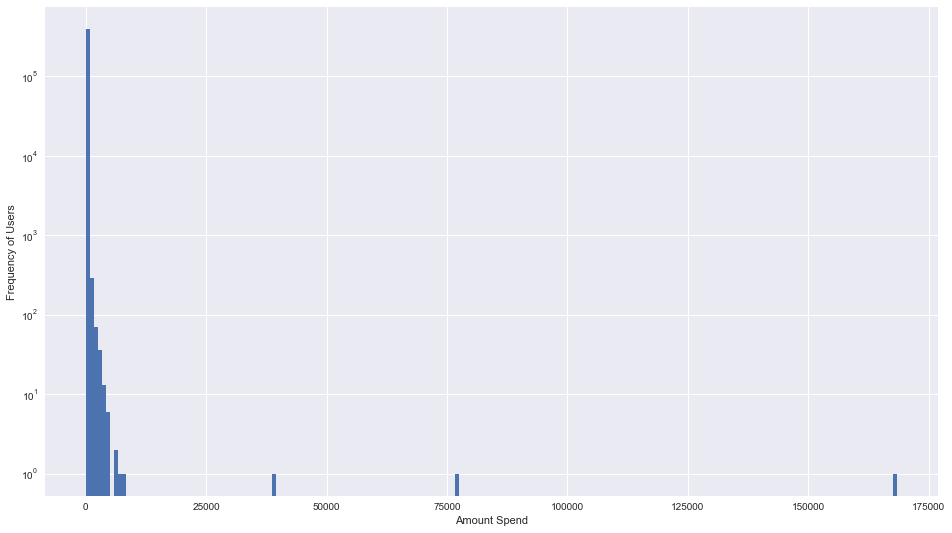

In [10]:
#plotting the amount spend

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

import seaborn as sns
sns.set()
plt.hist(matrix_setup['AmountSpend'],bins=200, log=True)
plt.xlabel('Amount Spend')
plt.ylabel('Frequency of Users')
plt.show()

In [11]:
# removing outliers

matrix_setup = matrix_setup[(matrix_setup['AmountSpend'] < 5000)]

In [12]:
# Taking Mean of Amount Spend, adding all the similar transactions and then taking the mean
# Similar Transactions is when same User buys the same Item

import numpy as np
matrix_setup['Mean_amount'] = matrix_setup.groupby(['StockCode','CustomerID'])['AmountSpend'].transform(np.mean)

In [13]:
# DataFrame.drop_duplicates Interactions: where User and Item repeat
# As mean has been already taken in above step

matrix_toGO = matrix_setup.drop_duplicates(subset = ['StockCode','CustomerID'], keep = 'first') 

In [14]:

min_amt = min(matrix_toGO['Mean_amount'])
max_amt = max(matrix_toGO['Mean_amount'])
print min_amt
print max_amt

0.0
4776.75


In [15]:
# Normalized data [0,1] using min-max approach 

matrix_toGO['Norm_Tot_Amnt']= (matrix_toGO['Mean_amount'] -min_amt)/(max_amt - min_amt)

C:\ProgramData\Anaconda\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:

lower_bound = min(matrix_toGO['Norm_Tot_Amnt'])
upper_bound = max(matrix_toGO['Norm_Tot_Amnt'])
print lower_bound
print upper_bound

0.0
1.0


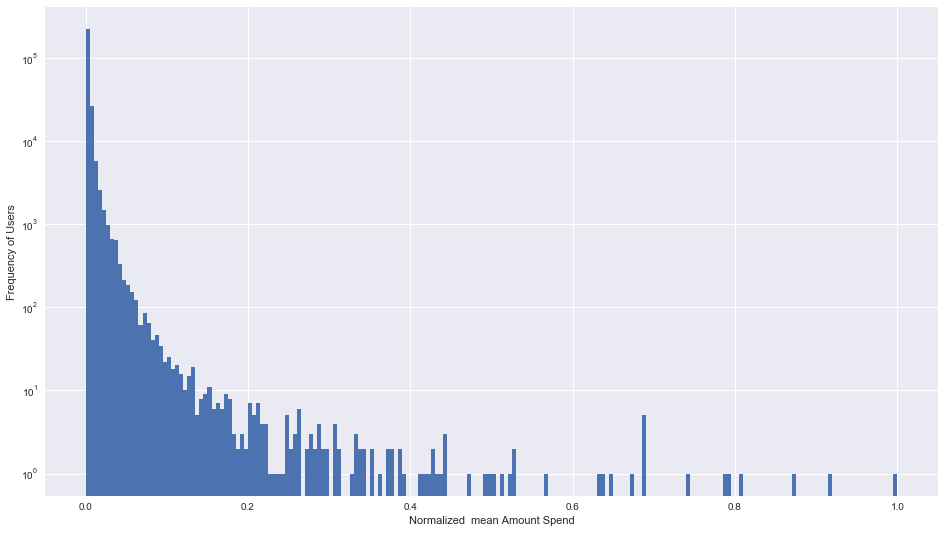

In [17]:
# Plotting Normalized Mean Amount Spend by Users 
plt.rcParams["figure.figsize"] = [16,9]
sns.set()
plt.hist(matrix_toGO['Norm_Tot_Amnt'],bins=200, log=True)
plt.xlabel('Normalized  mean Amount Spend')
plt.ylabel('Frequency of Users')
plt.show()

In [18]:
percentage_outliers =(float(matrix_toGO[matrix_toGO['Norm_Tot_Amnt'] > 0.4].count()[0])/(matrix_toGO[matrix_toGO['Norm_Tot_Amnt'] <= 0.4].count()[0]))*100
print 'Percentage of Outliers',percentage_outliers, '%'

Percentage of Outliers 0.013120260305964469 %


In [19]:
# Removing Long Tail Outliers
dfx=matrix_toGO[matrix_toGO['Norm_Tot_Amnt'] <= 0.4]

In [20]:
# keeping Normalized  amount above Zero
#dfx.loc[dfx['Norm_Tot_Amnt'] == 0, 'Norm_Tot_Amnt'] = 0.000001

In [21]:
# Final min-max of data or Upper - Lower bound
lower_bound = min(dfx['Norm_Tot_Amnt'])
upper_bound = max(dfx['Norm_Tot_Amnt'])
print lower_bound
print upper_bound

0.0
0.391031559114


In [22]:
#UNIQUE Values 
#exploring the unique values of each attribute

print("Number of products bought: ",dfx['StockCode'].nunique())
print("Number of customers:", dfx['CustomerID'].nunique() )

('Number of products bought: ', 3663)
('Number of customers:', 4334)


In [23]:
# Importing all packages for Latent factor modeling
from surprise import SVD,NMF,SVDpp,evaluate
from surprise.dataset import Dataset
from surprise import Reader

In [24]:
#define the reader  with  upper and lower bounds , also now we are predicting Normalized Total Amount column
reader_x = Reader(rating_scale = (lower_bound,upper_bound))

In [25]:
# for 50:50 distribution of the dataset
# find the dataframe index number which marks 50 percent of dataset
mark_50 = (dfx.shape[0]/100)*50
mark_50

133350

In [26]:
# refereshing the index of dataset. This is required because after deletion of few records, index has missing entities
dfx = dfx.reset_index(drop=True)

In [27]:
# splitting the Dataset  for compairing how Training and Test Amount are distributed
# The comparison can be seen in below two cells, the histogram plots
new_dfx_50 = dfx[0:mark_50]
new_dfx_50 = dfx[mark_50+1:]

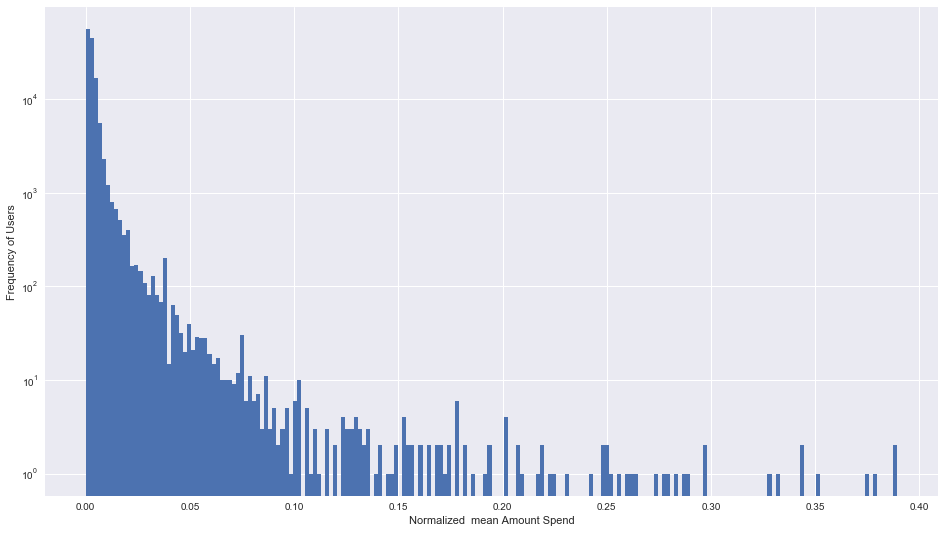

In [28]:
# Training Data plot
sns.set()
plt.hist(new_dfx_50['Norm_Tot_Amnt'],bins=200, log=True)
plt.xlabel('Normalized  mean Amount Spend')
plt.ylabel('Frequency of Users')
plt.show()

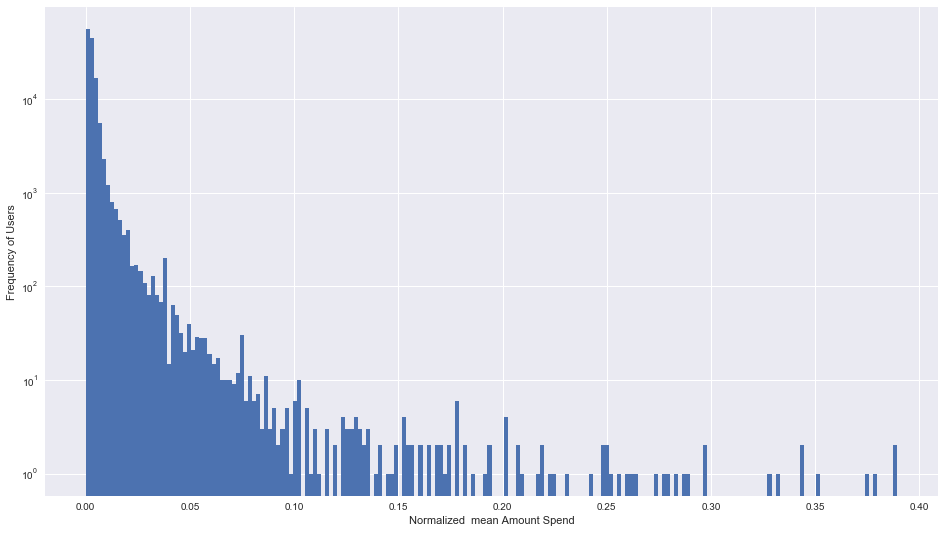

In [29]:
# Test Data plot
sns.set()
plt.hist(new_dfx_50['Norm_Tot_Amnt'],bins=200, log=True)
plt.xlabel('Normalized  mean Amount Spend')
plt.ylabel('Frequency of Users')
plt.show()

In [30]:
# Reading the Data
data = Dataset.load_from_df(df=dfx[['CustomerID','StockCode','Norm_Tot_Amnt']],reader=reader_x)

In [31]:
# Splitting the dataset based on Timestamp for Traing and Testing
dfx_50 = data.raw_ratings[0:mark_50]
test_50 = data.raw_ratings[mark_50+1:]
len(dfx_50)

133350

In [32]:
print (data.raw_ratings[0][2] - data.df['Norm_Tot_Amnt'][0])

1.0


In [33]:
# Choosing the Model
# Setting up the Model  using best hyper parameters 
# GridSearch has been performed to get these hyperparameter setting: best RMSE
#param_grid = {'n_factors': 2, 'reg_qi': 0.1, 'reg_pu': 0.01, 'n_epochs': 50}
#grid_search = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=1)

algo = NMF(n_factors=2, reg_qi = 0.1, reg_pu = 0.01 ,n_epochs=50)

In [34]:
#creating the traingset afer
trainset = data.construct_trainset(dfx_50)

#creating the testset
testset = data.construct_testset(test_50)

In [35]:
# Train the algorithm on the trainset, and predict ratings for the testset

# check out time
import time
start_time = time.time()
algo.fit(trainset)
print("---%s Time required for Traing the Model in seconds-----" % (time.time() - start_time))



---3.47399997711 Time required for Traing the Model in seconds-----


In [36]:
# Predictions
start_time = time.time()

predictions = algo.test(testset)
print("---%s Time required for Prediction in seconds----" % (time.time() - start_time))

---1.1400001049 Time required for Prediction in seconds----


In [37]:
# Then compute RMSE,MAE

from surprise import accuracy
print 'RMSE over test set ', accuracy.rmse(predictions)
print 'MAE over test set ',accuracy.mae(predictions)

RMSE over test set RMSE: 0.0079
 0.007926590670410929
MAE over test set MAE:  0.0032
 0.003214552582412338


In [38]:
# List of Test Amount
test_list = []
for i in testset:
    test_list.append(i[-1] -1)

In [39]:
# List of Predicted Amount
prediction_list = []
for i in predictions:
    prediction_list.append(i[3])

Text(0,0.5,u'Test')

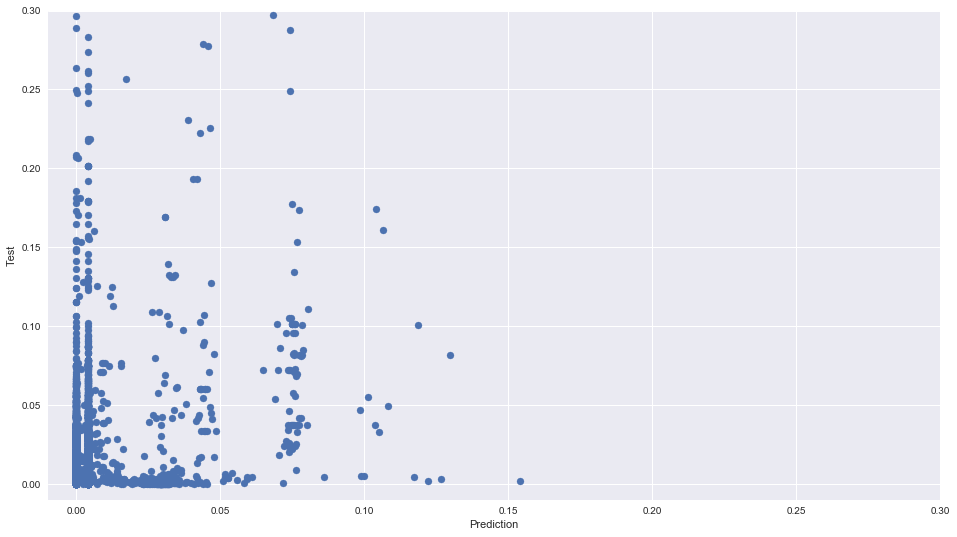

In [40]:
# Plotting Prediction v/s Test Data
plt.scatter(prediction_list,test_list)
plt.xlim(-0.01,0.30)
plt.ylim(-0.01,0.30)
plt.xlabel('Prediction')
plt.ylabel('Test')

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(algo.pu)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

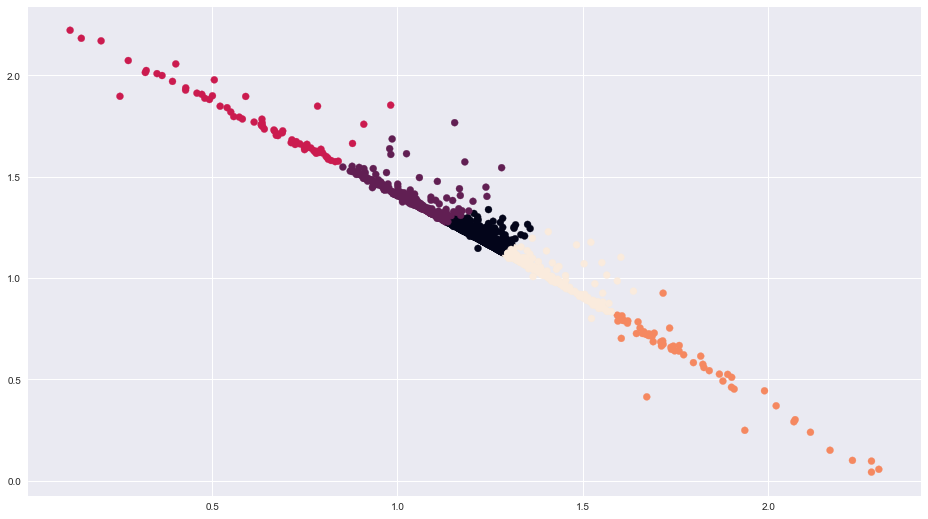

In [42]:
# plotting the users as clusters
plt.scatter(algo.pu[:, 0], algo.pu[:, 1], c=kmeans.labels_)

In [43]:
Users_Y = [y for y in np.where(kmeans.labels_ == 2) ]
Users_X = [x for x in np.where(kmeans.labels_ == 4) ]
counter = []
real_user_x = trainset.to_raw_uid(Users_X[0][0])
set_of_items_real_user = matrix_setup['StockCode'][matrix_setup['CustomerID'] == real_user_x]
set_of_items_real_user = set_of_items_real_user.to_frame()
for i in Users_X[0][1:]:
    neighbor_user_x = trainset.to_raw_uid(i)
    set_of_items_neighbor = matrix_setup['StockCode'][matrix_setup['CustomerID'] == neighbor_user_x]
    set_of_items_neighbor = set_of_items_neighbor.to_frame()
    print (set_of_items_real_user.merge(set_of_items_neighbor)).count()
    counter.append((set_of_items_real_user.merge(set_of_items_neighbor)).count()[0])


    

StockCode    6
dtype: int64
StockCode    0
dtype: int64
StockCode    19
dtype: int64
StockCode    0
dtype: int64
StockCode    36
dtype: int64
StockCode    51
dtype: int64
StockCode    22
dtype: int64
StockCode    8
dtype: int64
StockCode    9
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    4
dtype: int64
StockCode    4
dtype: int64
StockCode    0
dtype: int64
StockCode    14
dtype: int64
StockCode    0
dtype: int64
StockCode    58
dtype: int64
StockCode    1
dtype: int64
StockCode    0
dtype: int64
StockCode    1
dtype: int64
StockCode    19
dtype: int64
StockCode    0
dtype: int64
StockCode    2
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    31
dtype: int64
StockCode    6
dtype: int64
StockCode    7
dtype: int64
StockCode    2
dtype: int64
StockCode    19
dtype: int64
StockCode  

StockCode    32
dtype: int64
StockCode    22
dtype: int64
StockCode    12
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    2
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    6
dtype: int64
StockCode    3
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    6
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    3
dtype: int64
StockCode    29
dtype: int64
StockCode    22
dtype: int64
StockCode    1
dtype: int64
StockCode    3
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    3
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    1
dtype: int64
StockCode    9
dtype: int64
StockCode    0
dtype: int64
StockCode    9


In [44]:

user_y_counter = []
for i in Users_Y[0]:
    user_y = trainset.to_raw_uid(i)
    set_of_items_y = matrix_setup['StockCode'][matrix_setup['CustomerID'] == user_y]
    set_of_items_y = set_of_items_y.to_frame()
    #print (set_of_items_real_user.merge(set_of_items_y)).count()
    user_y_counter.append((set_of_items_real_user.merge(set_of_items_y)).count()[0])

In [45]:
#check similar items bought by users of other clusters 
print 'Another Cluster: max intersection of items #',np.array(user_y_counter).max(),' with the first user'
print 'Another Cluster: Total number of intersection of items #',np.array(user_y_counter).sum(),' with the first user'

Another Cluster: max intersection of items # 70  with the first user
Another Cluster: Total number of intersection of items # 357  with the first user


In [46]:
# Keeping first user as our focal point
# check similar items bought by neighbors
print 'Same Cluster: max intersection of items #',np.array(counter).max(),' with the first user'
print 'Same Cluster: Total number of intersection of items #',np.array(counter).sum(),' with the first user'

Same Cluster: max intersection of items # 153  with the first user
Same Cluster: Total number of intersection of items # 3524  with the first user
